In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path
import io
import base64
import random

import gym
from gym import wrappers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from lib import get_network
from lib.agent import DQN
from lib.logging import Logger
from lib.rollout import ReplayBuffer
from lib.utils import make_env, get_html_video_string, train, plot_progress

from IPython.display import HTML

plt.style.use('seaborn-v0_8')

### In this assignment you are going to:
* implement DQN and doubleDQN
* use them on CartPole, LunarLander and (Optionally) BreakOut environments

### We use PyTorch for neural networks. If you are new to PyTorch see tutorials:
https://pytorch.org/tutorials/ <br>
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [3]:
SEED = 0xCEEEEEEB
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
log_root = Path("results")
log_root.mkdir(exist_ok=True)

# LunarLander

Okay, now that we're done with very simple CartPole environment, let's move to something more complicated. 

LunarLander is a simulation game where a player has to control the capsule and land it on the zone marked with flags. If an agent achieves more than 200 scores, the environment is said to be solved.

##### The random policy quickly fails the task:

In [5]:
env = make_env("LunarLander-v2", monitor=True)
env.reset()
while True:
    action = env.action_space.sample()
    if env.step(action)[2]: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

#### Task 3: Play a bit with hyperparameters. You have to gain some intuition about what each of them does. You have to achieve mean score of 200 in ~200 000 iterations

In [6]:
env = make_env("LunarLander-v2", SEED)

value_network = get_network("mlp")(
    env.observation_space.shape[0],
    64,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=.2,
    eps_decay=(.2 - .02) / 10**5,
    batch_size=32,
    learning_rate=5e-4,
    discount_factor=.99,
)

In [7]:
agent = train(
    agent,
    env,
    log_dir=log_root / "lunarlander-v2",
    prefix="_dqn",
    buffer_size=5 * 10**4,
    n_steps=2*10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=4000,
    save_every=1000
)

/home/vsydorskyi/src/rl-assignments/lib/agent.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  v_s0 = FloatTensor(v_s0)


---------------------------------
| reward/reward_mean | -182.34  |
| reward/reward_max  | 76.933   |
| reward/reward_min  | -430.65  |
| reward/reward_std  | 122.54   |
| loss/bellman_error | 1.8085   |
| misc/q             | -1.2689  |
| misc/q_est         | -0.71107 |
| misc/epsilon       | 0.1928   |
| misc/timestep      | 4000     |
---------------------------------
---------------------------------
| reward/reward_mean | -226.71  |
| reward/reward_max  | 214.38   |
| reward/reward_min  | -635.38  |
| reward/reward_std  | 192.96   |
| loss/bellman_error | 1.4527   |
| misc/q             | 0.20392  |
| misc/q_est         | 0.44252  |
| misc/epsilon       | 0.1856   |
| misc/timestep      | 8000     |
---------------------------------
---------------------------------
| reward/reward_mean | -110     |
| reward/reward_max  | 158.48   |
| reward/reward_min  | -605.68  |
| reward/reward_std  | 157.5    |
| loss/bellman_error | 1.4997   |
| misc/q             | 1.0753   |
| misc/q_est  

In [8]:
env = make_env("LunarLander-v2", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

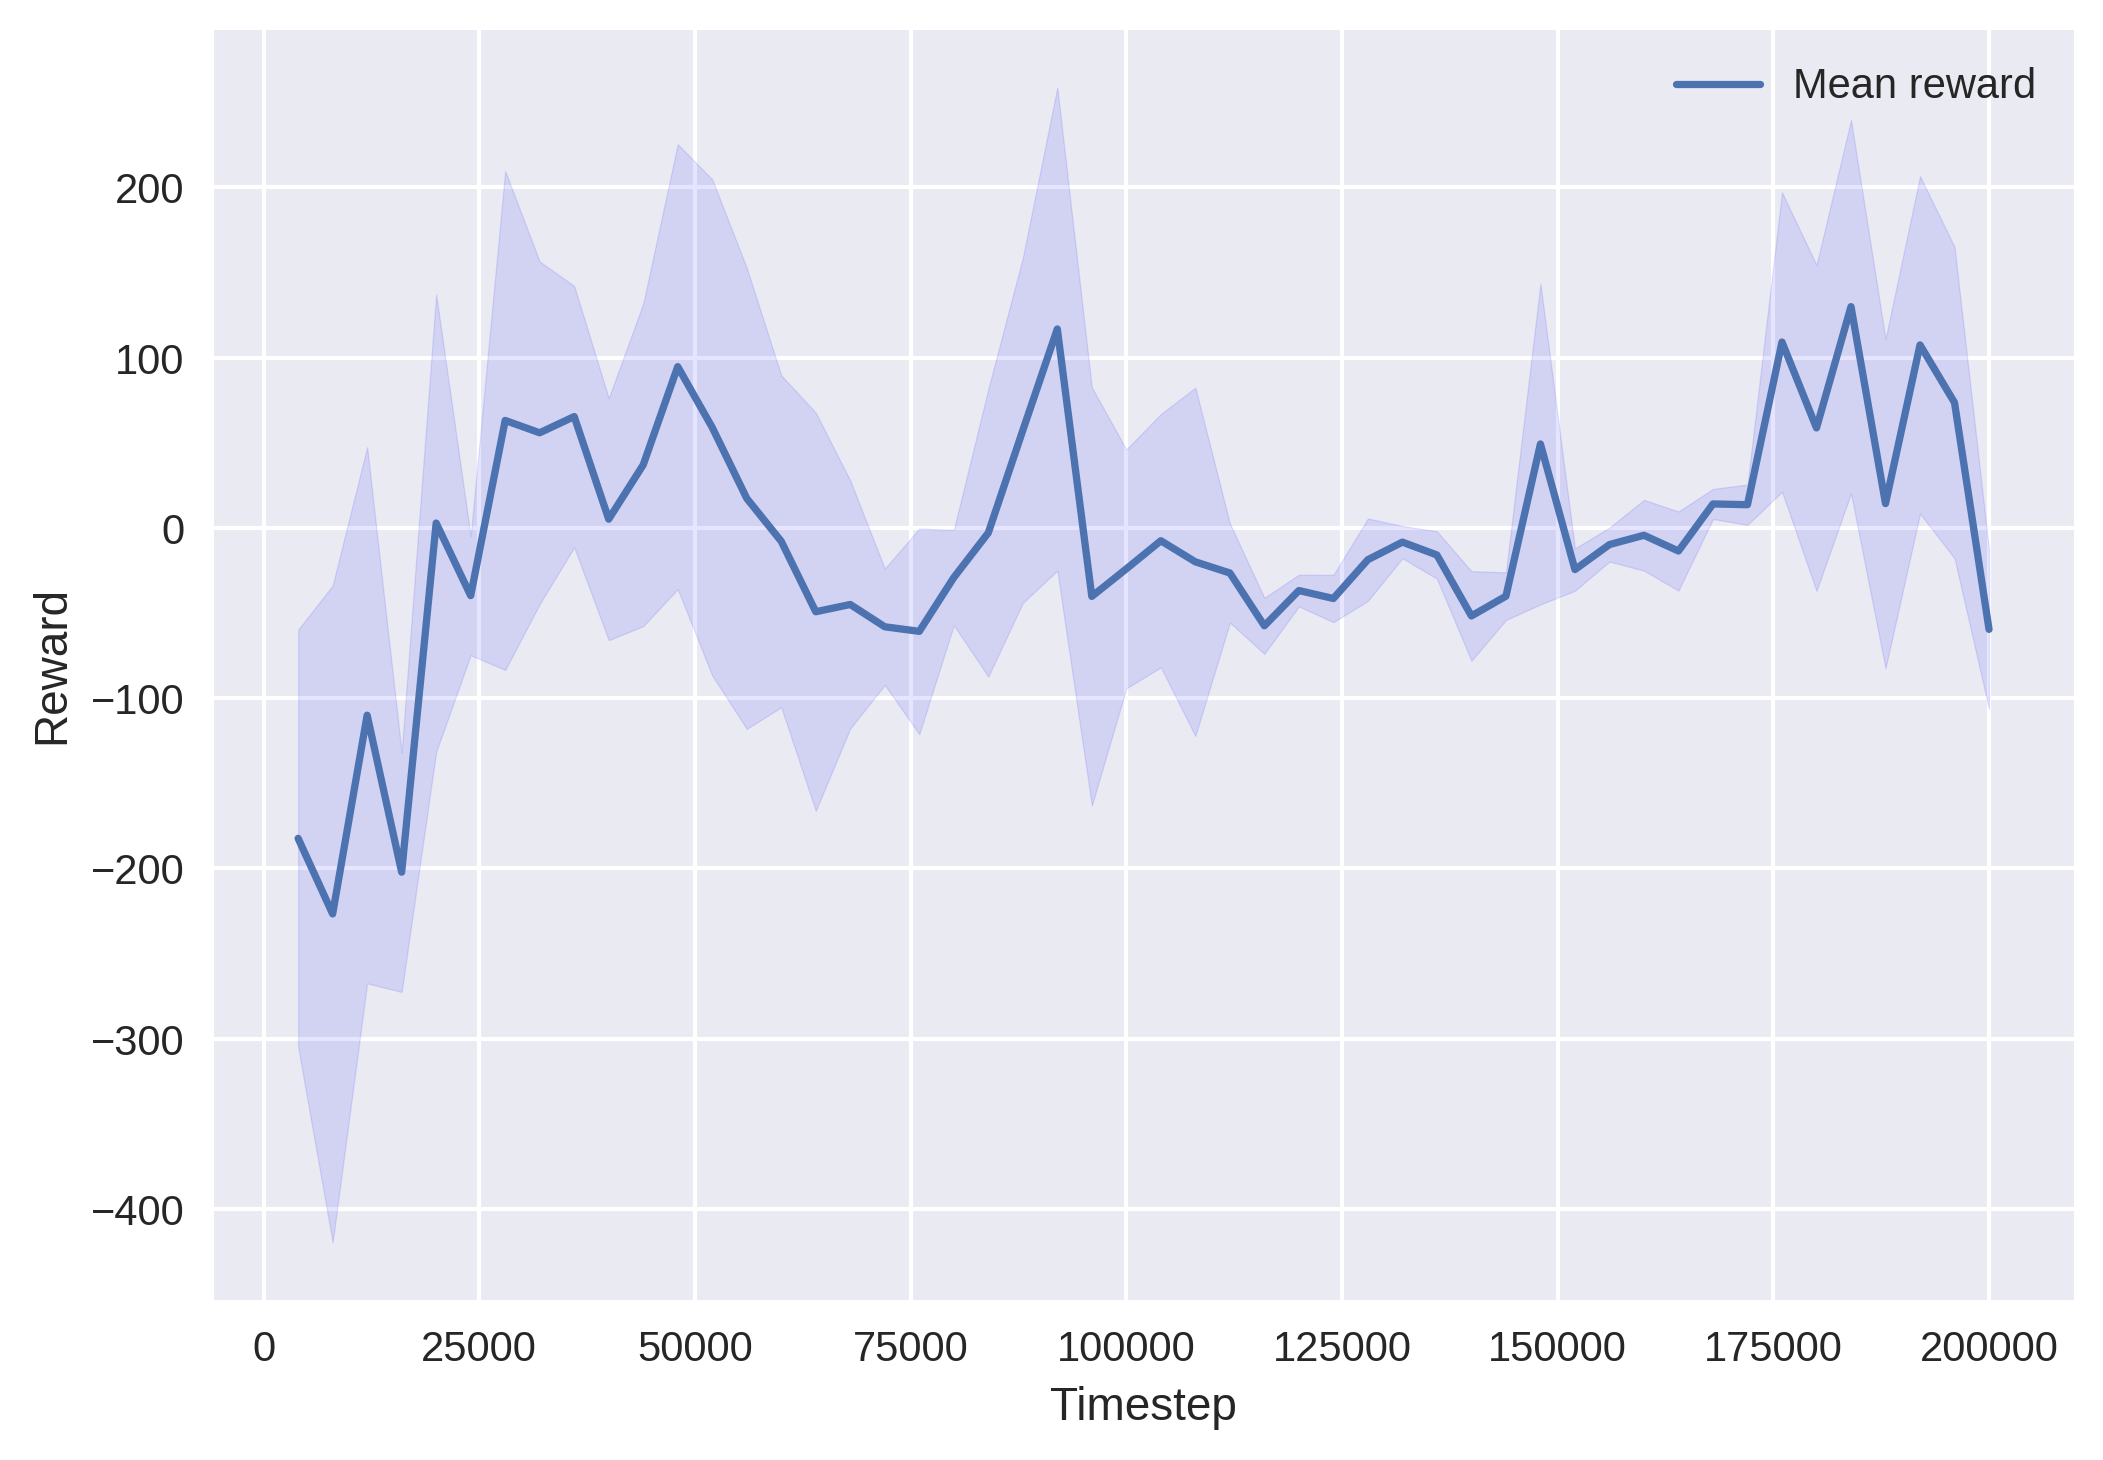

In [11]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "lunarlander-v2" / "logs_dqn.csv"), sep=";")
plot_progress(df)

## Double DQN

One of the main drawbacks of vanila DQN is that it overestimates Q-values. More details could be found in the original paper. In a couple of words, we have to estimate an expecation of maximum, not a maximum of expectations as we do in vanila DQN. The trick is to use the second network for the updates (we use target network for this):

$$y = r + \gamma Q_{target}(s^\prime, \text{argmax}_a Q(s^\prime, a) )$$

Compared to 

$$y = r + \gamma Q_{target}(s^\prime, \text{argmax}_a Q_{target}(s^\prime, a) )$$

from vanila DQN. Which is the same as:

$$y = r + \gamma \text{max}_a Q_{target}(s^\prime, a)$$

Double Q-learning paper: https://papers.nips.cc/paper/3964-double-q-learning <br>
Double DQN paper: https://arxiv.org/abs/1509.06461

#### Task 4. Implement Double DQN in `lib/agent.py`. 

 Now, let's try it for the LunarLander environment:

In [12]:
env = make_env("LunarLander-v2", SEED)

value_network = get_network("mlp")(
    env.observation_space.shape[0],
    64,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=0.2,
    eps_decay=(.2 - .02) / 10**5,
    batch_size=32,
    learning_rate=5e-4,
    discount_factor=0.99,
    double=True
)

In [13]:
agent = train(
    agent,
    env,
    log_dir=log_root / "lunarlander-v2",
    prefix="_double_dqn",
    buffer_size=5 * 10**4,
    n_steps=2*10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=4000,
    save_every=1000
)

---------------------------------
| reward/reward_mean | -232.83  |
| reward/reward_max  | -5.3263  |
| reward/reward_min  | -528.28  |
| reward/reward_std  | 141.07   |
| loss/bellman_error | 1.7463   |
| misc/q             | -2.6225  |
| misc/q_est         | -2.0042  |
| misc/epsilon       | 0.1928   |
| misc/timestep      | 4000     |
---------------------------------
---------------------------------
| reward/reward_mean | -174.73  |
| reward/reward_max  | -79.964  |
| reward/reward_min  | -301.02  |
| reward/reward_std  | 73.768   |
| loss/bellman_error | 1.4308   |
| misc/q             | -2.2806  |
| misc/q_est         | -2.0281  |
| misc/epsilon       | 0.1856   |
| misc/timestep      | 8000     |
---------------------------------
---------------------------------
| reward/reward_mean | 3.3246   |
| reward/reward_max  | 201.88   |
| reward/reward_min  | -66.689  |
| reward/reward_std  | 101.86   |
| loss/bellman_error | 1.3587   |
| misc/q             | -0.86454 |
| misc/q_est  

### You should obtain better curve for Double DQN, however it is not always the case. For such environent the improvement could be neglectable. Although, you have to at least reach the same performance. 
### You may want to compare the performance on _CartPole_ as, unlike _LunarLander_ , its reward function is dense. However, it may be too simple to reveal any difference.
### Thus, it is much better to compare DQN and Double DQN on Atari benchmark.

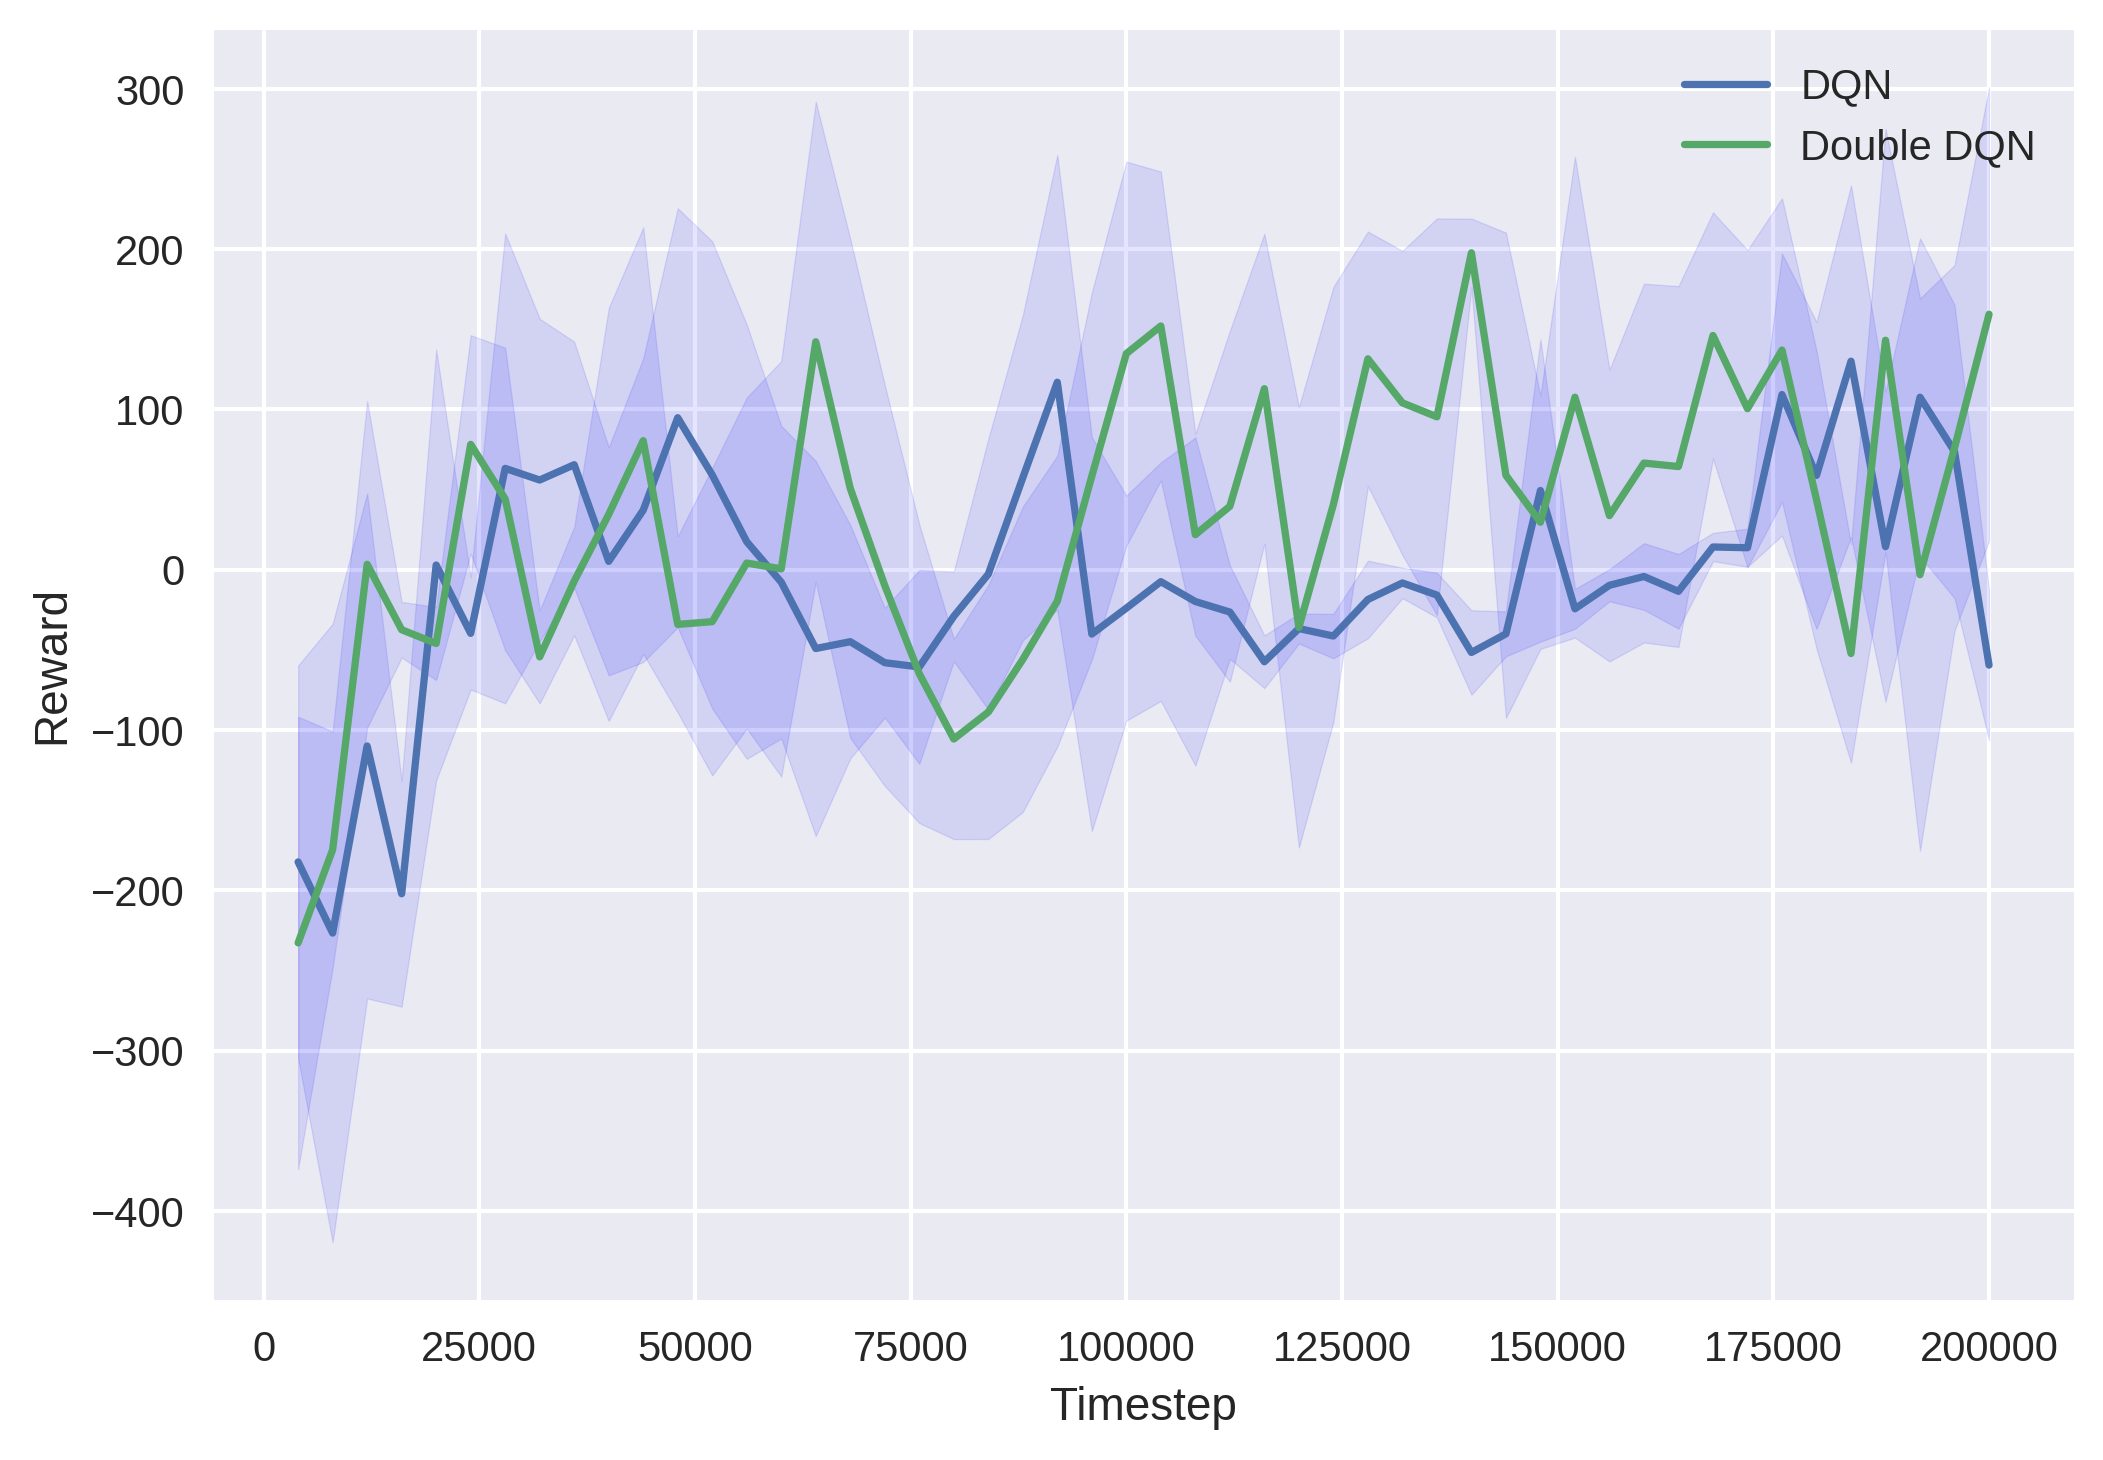

In [14]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "lunarlander-v2" / "logs_dqn.csv"), sep=";")
df_double = pd.read_csv(str(log_root / "lunarlander-v2" / "logs_double_dqn.csv"), sep=";")
plot_progress(df, "DQN")
plot_progress(df_double, "Double DQN")

### Look at the graphs of estimated Q values by DQN and Double DQN. Could you describe what's happening?

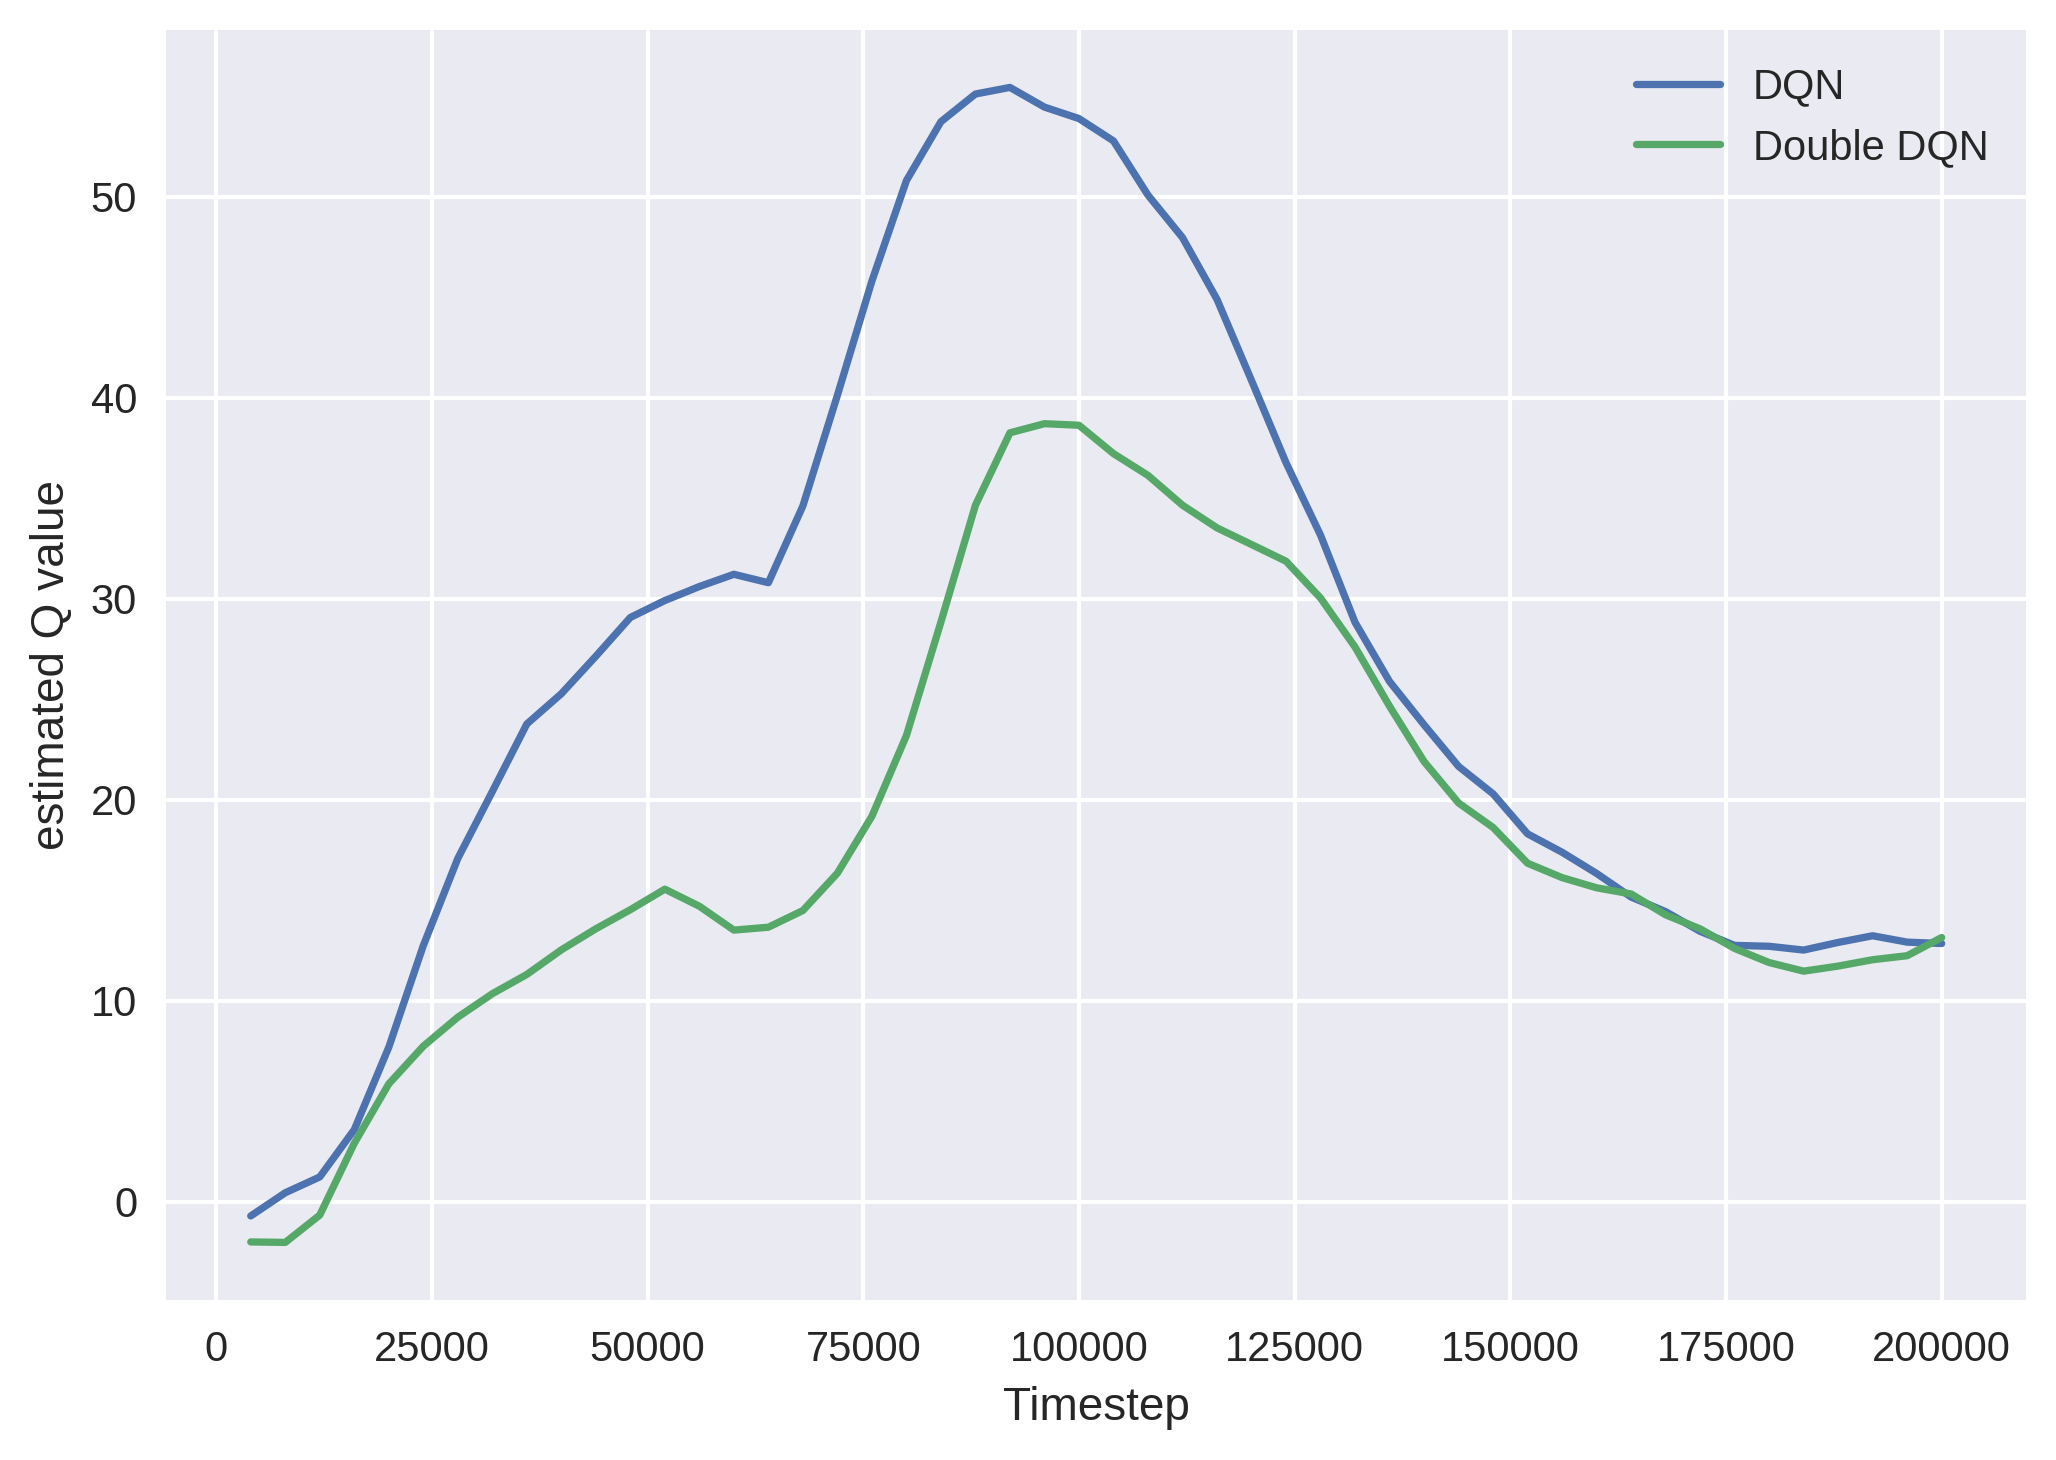

In [15]:
plt.figure(dpi=300)
plt.xlabel("Timestep")
plt.ylabel("estimated Q value")
plt.plot(df['misc/timestep'], df['misc/q_est'], label="DQN")
plt.plot(df_double['misc/timestep'], df_double['misc/q_est'], label="Double DQN")
plt.legend(loc="best");

Double DQN estimated Q values more correlate with reward rather then simple DQN estimated Q values